In [9]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from keras.preprocessing.sequence import pad_sequences

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 

%config InlineBackend.figure_format='retina'
%matplotlib inline

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

seed=123
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-12GB'

In [11]:
df=pd.read_csv('../PhD_Mission_2022/April_2022/Week_3/Combine_All_Severity.csv')

In [12]:
itTicketDF=df
itTicketDF['u_resolution_code']=itTicketDF['u_resolution_code']
itTicketDF = itTicketDF[df['u_resolution_code'].notnull()]

In [13]:
sample = itTicketDF.groupby(['u_resolution_code'])
regroup=[]
for grp in itTicketDF['u_resolution_code'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
itTicketDF['u_resolution_code']=itTicketDF['u_resolution_code'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
itTicketDF['u_resolution_code'].unique()

Found 18 groups which have under 10 samples


array(['Redirect To Service Catalog', 'Modify/Delete Data',
       'Modify Application Source Code', 'misc_grp',
       'User Resolved Issue', 'Password Reset',
       'ECC Facilitated Resolution', 'Workaround provided',
       'Unable To Recreate / No Action Taken', 'Working As Designed',
       'Education /Training', 'Hardware Replacement',
       'Close To Duplicate Incident', 'Unable To Contact User',
       'Workaround Provided', 'Modify Parameters / Settings',
       'Redirect To Support Organization',
       'Redirect to Self-Service portal', 'Full Walk Through',
       'Referred To Vendor', 'Redirect To Wsr/Faq/Self Help Tool',
       'Vendor Resolved', 'Modify Permissions',
       'Unlock Account / Transaction',
       'Redirect To WSR/FAQ/Self Help Tool', 'Investigation Performed',
       'File / Data Restored / Resent', 'Successfully Navigated',
       'Install/Reinstall/Uninstall Software',
       'Reboot / Restart Workstation', 'Create/Recreate Account',
       'Reset Conn

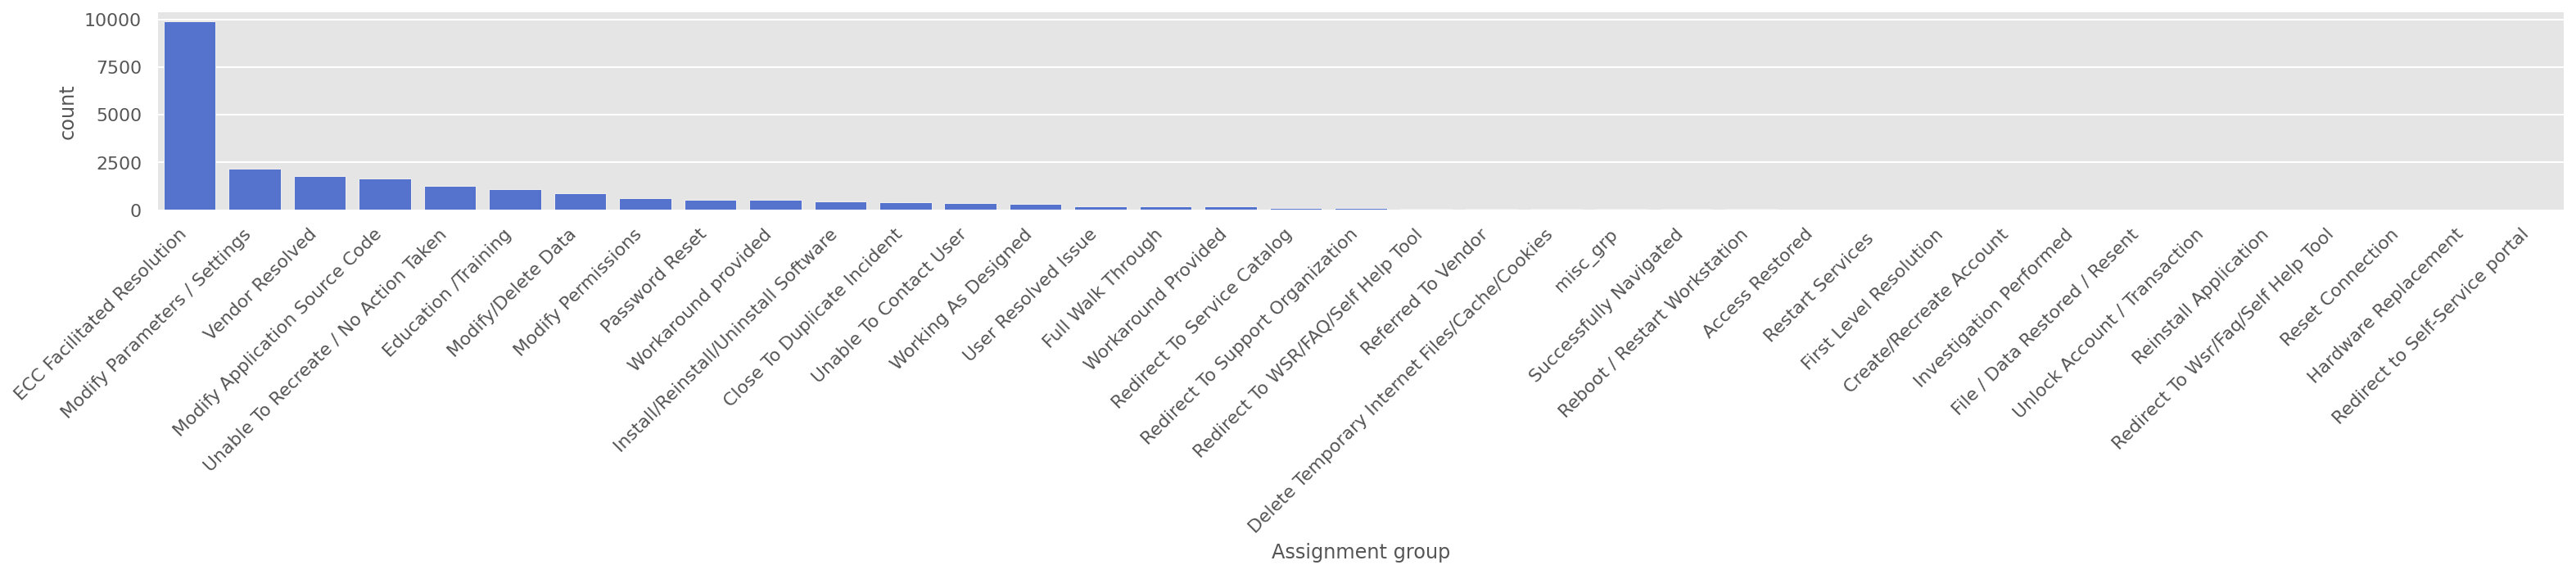

In [14]:
##Pre-Processing label Encoding on  u_resolution_code
import seaborn as sns
import matplotlib.pyplot as plt
#add to remove warning for python 3.6 dependency
import warnings
import pandas.util.testing as tm
plt.style.use('ggplot')
%matplotlib inline

descending_order = itTicketDF['u_resolution_code'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='u_resolution_code', data=itTicketDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [15]:
maxOthers = itTicketDF['u_resolution_code'].value_counts().max()
maxOthers

9906

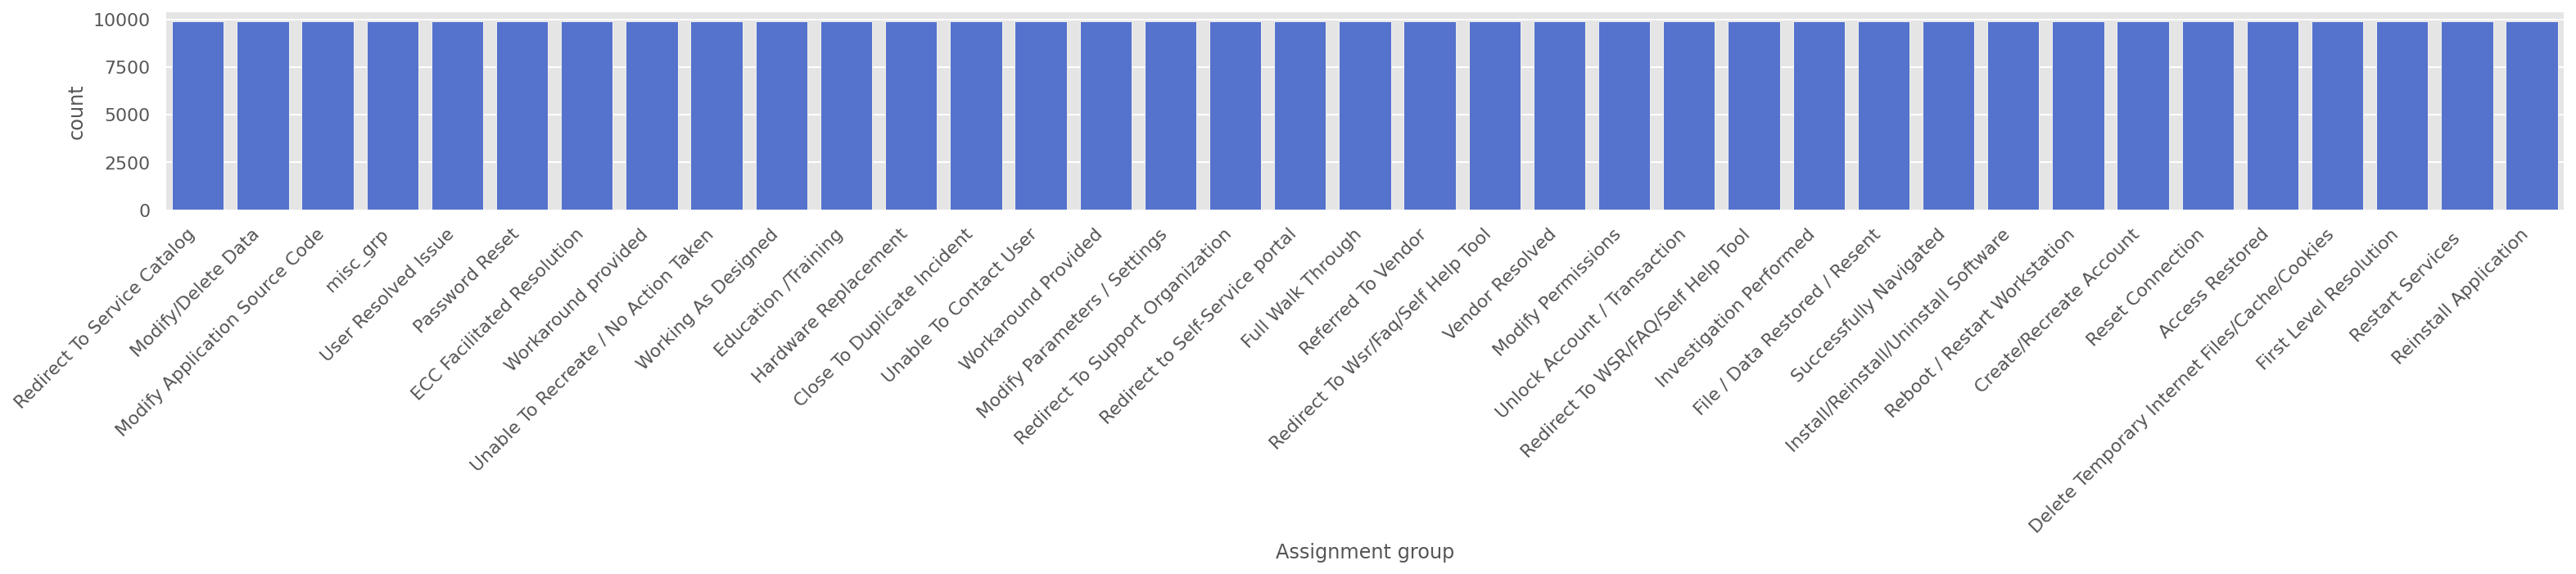

In [16]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.This is for us to try creating a single model which use the whiole dataset & verify the performance
from sklearn.utils import resample
itTicketDF_resampled = itTicketDF[0:0]
for grp in itTicketDF['u_resolution_code'].unique():
    itTicketGrpDF = itTicketDF[itTicketDF['u_resolution_code'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    itTicketDF_resampled = itTicketDF_resampled.append(resampled)

descending_order = itTicketDF_resampled['u_resolution_code'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='u_resolution_code', data=itTicketDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
#otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['u_resolution_code'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['u_resolution_code'])
#itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

In [18]:
df=itTicketDF_resampled

In [19]:
df['Inbound Message'] = df['text']
df['Label']= df['u_resolution_code']

In [20]:
df_train,df_test=train_test_split(df,test_size=0.2 ,random_state=123)  # 80% train & 10 % validation & 10% test set
#df_val,df_test=train_test_split(df_val,test_size=0.5 ,random_state=123)
df_val=df_test
print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape} ')
print(f'Testing dataset : {df_test.shape}') 
#print(f'Validation dataset : {df_val.shape}')

Print the shape of datasets...
Training dataset : (293217, 49) 
Testing dataset : (73305, 49)


In [16]:
from transformers import BertTokenizer, BertModel
pre_trained_BERTmodel='bert-base-uncased'
BERT_tokenizer=BertTokenizer.from_pretrained(pre_trained_BERTmodel, do_lower_case=False)

In [19]:
token_lens=[]
for message in df_train['Inbound Message']:
  tokens_message=BERT_tokenizer.encode(message, max_length=35,truncation=True)
  token_lens.append(len(tokens_message))

Text(0.5, 0, 'Token count')

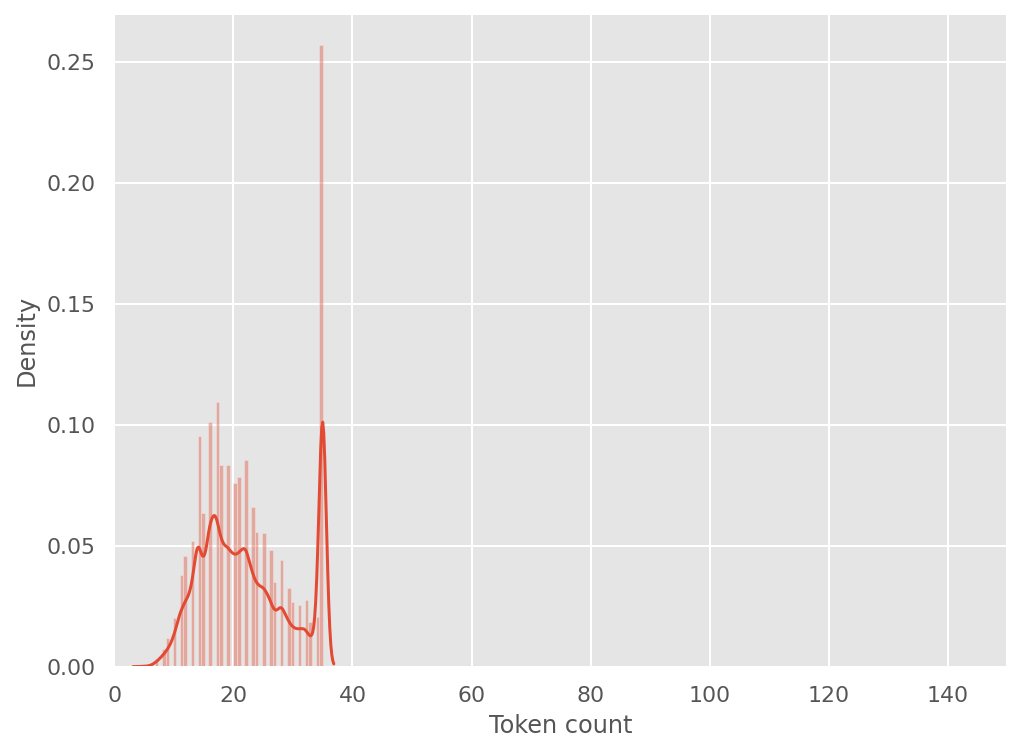

In [20]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

In [16]:
class message_Dataset(Dataset):

  def __init__(self, messages, targets, tokenizer, max_length):
    self.messages=messages
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.messages)

  def __getitem__(self,item):
    message = str(self.messages[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        message,
        max_length=Max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'message_text':message,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(targets,dtype=torch.long)
    }

In [22]:
batch_size=8
Max_length= 35
def data_loader(df,tokenizer, max_length, batch):
  ds=message_Dataset(
      messages=df['Inbound Message'].to_numpy(),
      targets=df['Label'].to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train, BERT_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test, BERT_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_test, BERT_tokenizer,Max_length,batch_size)

In [23]:
BERT_data=next(iter(train_DataLoader))
BERT_data.keys()

dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
#dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])
print('Shape of the BERT_data keys...')
print(f"Input_ids : {BERT_data['input_ids'].shape}")
print(f"Attention_mask : {BERT_data['attention_mask'].shape}")
print(f"targets : {BERT_data['targets'].shape}")

Shape of the BERT_data keys...
Input_ids : torch.Size([8, 35])
Attention_mask : torch.Size([8, 35])
targets : torch.Size([8])


In [25]:
input_ids = BERT_data['input_ids'].to(device)
attention_mask = BERT_data['attention_mask'].to(device)
targets=BERT_data['targets'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 35])
torch.Size([8, 35])


In [26]:
BERT_model = BertModel.from_pretrained(pre_trained_BERTmodel)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
n_classes=df['Label'].nunique()

In [28]:
class BERT_Text(nn.Module):
   def __init__(self, n_classes):
     super(BERT_SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(pre_trained_BERTmodel)
     ### New layers:
     self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
     self.drop = nn.Dropout(p=float(0.6))
     self.linear = nn.Linear(256*2, n_classes)
     #self.drop1 = nn.Dropout(p=float(0.1))
     #self.hidden=nn.Linear(self.bert.config.hidden_size,256)
     #self.drop2 = nn.Dropout(p=float(0.1))
     #self.out = nn.Linear(256, n_classes)
   def forward(self, input_ids, attention_mask):
     sequence_output, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
     # sequence_output has the following shape: (batch_size, sequence_length, 768)
     lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
     hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
     output = self.drop(lstm_output)
     linear_output = self.linear(output[:,-1].view(-1,256*2)) ### We are only using the output of the last LSTM cell to perform classification

     #output = self.drop1(pooled_output)
     #output=self.hidden(output)
     #output = self.drop2(output)
     #output=self.out(output)
     return linear_output

In [29]:
BERT_model = BERT_Text(n_classes)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
F.softmax(BERT_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.0292, 0.0295, 0.0315, 0.0225, 0.0288, 0.0320, 0.0279, 0.0326, 0.0237,
         0.0292, 0.0284, 0.0265, 0.0215, 0.0266, 0.0266, 0.0269, 0.0244, 0.0249,
         0.0304, 0.0282, 0.0294, 0.0290, 0.0243, 0.0252, 0.0272, 0.0223, 0.0261,
         0.0272, 0.0241, 0.0328, 0.0267, 0.0268, 0.0298, 0.0234, 0.0268, 0.0228,
         0.0249],
        [0.0256, 0.0296, 0.0270, 0.0257, 0.0308, 0.0343, 0.0307, 0.0263, 0.0255,
         0.0245, 0.0259, 0.0264, 0.0209, 0.0256, 0.0264, 0.0281, 0.0277, 0.0255,
         0.0282, 0.0278, 0.0243, 0.0226, 0.0285, 0.0306, 0.0308, 0.0292, 0.0278,
         0.0282, 0.0302, 0.0268, 0.0248, 0.0240, 0.0250, 0.0316, 0.0249, 0.0227,
         0.0255],
        [0.0324, 0.0304, 0.0280, 0.0213, 0.0236, 0.0291, 0.0289, 0.0317, 0.0236,
         0.0286, 0.0213, 0.0234, 0.0189, 0.0293, 0.0226, 0.0266, 0.0306, 0.0282,
         0.0288, 0.0292, 0.0289, 0.0257, 0.0255, 0.0359, 0.0253, 0.0247, 0.0213,
         0.0282, 0.0244, 0.0340, 0.0316, 0.0321, 0.0235, 0.0313, 0.0236, 

In [32]:
epochs=1
optimizer=AdamW(BERT_model.parameters(),lr=1e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

In [33]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

In [57]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

In [36]:
%%time
import time 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  t0 = time.time() 
  train_acc, train_loss = train(
    BERT_model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  for step, batch in enumerate(train_DataLoader):

        # Progress update every 40 batches.
        if step % 1000 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_DataLoader), elapsed))    

  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    BERT_model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_val)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(BERT_model.state_dict(), 'best_BERT_model_allstatetextres_resampled_gpu.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
  Batch 1,000  of  36,653.    Elapsed: 19915.37249994278.
  Batch 2,000  of  36,653.    Elapsed: 19917.292340755463.
  Batch 3,000  of  36,653.    Elapsed: 19919.09976530075.
  Batch 4,000  of  36,653.    Elapsed: 19920.767714500427.
  Batch 5,000  of  36,653.    Elapsed: 19922.527268886566.
  Batch 6,000  of  36,653.    Elapsed: 19924.2558324337.
  Batch 7,000  of  36,653.    Elapsed: 19926.039184093475.
  Batch 8,000  of  36,653.    Elapsed: 19927.746663570404.
  Batch 9,000  of  36,653.    Elapsed: 19929.45051908493.
  Batch 10,000  of  36,653.    Elapsed: 19931.15467429161.
  Batch 11,000  of  36,653.    Elapsed: 19932.883715867996.
  Batch 12,000  of  36,653.    Elapsed: 19934.580985546112.
  Batch 13,000  of  36,653.    Elapsed: 19936.316095352173.
  Batch 14,000  of  36,653.    Elapsed: 19938.179079771042.
  Batch 15,000  of  36,653.    Elapsed: 19940.01333642006.
  Batch 16,000  of  36,653.    Elapsed: 19941.778279066086.
  Batch 17,000  of  36,653.    Elap

In [37]:
def get_predictions(model, data_loader):
  model = model.eval()
  messages = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["message_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      messages.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return messages, predictions, prediction_probs, real_values

In [38]:
messages, y_pred, y_pred_probs, y_test = get_predictions(
  BERT_model,
  test_DataLoader
)

In [1]:
# Calculate precision, recall, f1_score, & roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
precision_b, recall_b, f1_score_b, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy_b = accuracy_score(y_test, y_pred)
#auc_score_b = roc_auc_score(y_test, F.softmax(y_pred_probs), average = 'weighted', multi_class='ovo')
print(f'Precision for BERT : {round(precision_b,2)}')
print(f'Recall for BERT : {round(recall_b,2)}')
print(f'F1_score for BERT : {round(f1_score_b,2)}')
#print(f'AUC for BERT : {round(auc_score_b,2)}')
print(f'Accuracy score for BERT : {round(accuracy_b,2)}')

Precision for BERT : 0.90
Recall for BERT : 0.91
F1_score for BERT : 0.86
Accuracy score for BERT : 0.93


In [41]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2006
           1       0.90      0.88      0.89      1935
           2       0.95      1.00      0.98      1997
           3       0.88      1.00      0.94      1948
           4       0.82      0.86      0.84      2033
           5       0.70      0.30      0.42      1958
           6       0.96      1.00      0.98      1944
           7       0.80      0.90      0.84      1974
           8       0.78      0.76      0.77      1926
           9       1.00      1.00      1.00      1998
          10       0.56      0.77      0.65      2030
          11       0.91      0.96      0.94      2010
          12       0.95      0.93      0.94      2004
          13       0.69      0.63      0.66      1974
          14       0.82      0.79      0.81      1975
          15       0.92      0.88      0.90      1982
          16       0.94      0.90      0.92      1953
          17       0.97    

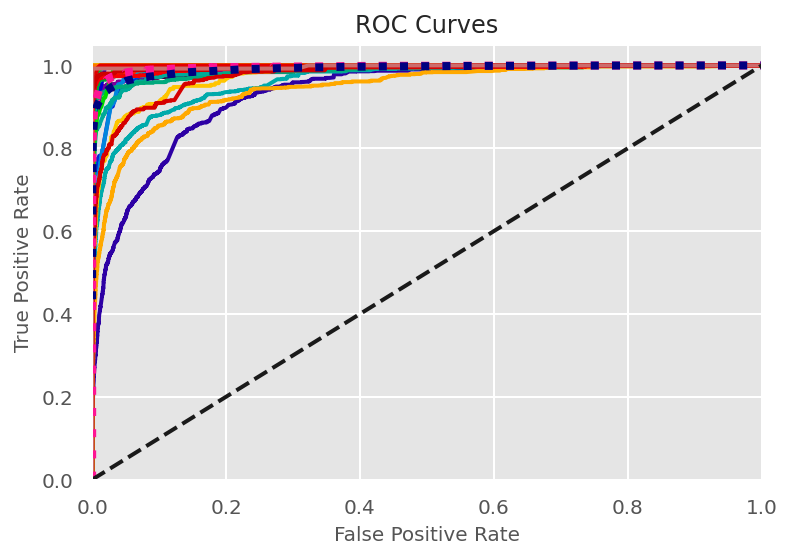

In [49]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test # ground truth labels
y_probas = y_pred_probs # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas )
plt.gca().get_legend().remove()
plt.savefig('BERT_itTicketDF_resampled_epoch.pdf', bbox_inches='tight')
plt.savefig('BERT_itTicketDF_resampled_epoch.pdf.png', bbox_inches='tight')
plt.show()

In [45]:
from torchsummary import summary
summary(BERT_model,input_size=(768,),depth=1,batch_dim=1, dtypes=['torch.IntTensor']) 

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         109,482,240
├─LSTM: 1-2                              2,101,248
├─Dropout: 1-3                           --
├─Linear: 1-4                            18,981
Total params: 111,602,469
Trainable params: 111,602,469
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         109,482,240
├─LSTM: 1-2                              2,101,248
├─Dropout: 1-3                           --
├─Linear: 1-4                            18,981
Total params: 111,602,469
Trainable params: 111,602,469
Non-trainable params: 0

----------------------------